# Chatbot with Profile Schema 

## Review

We introduced the [LangGraph Memory Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We built a simple chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

It saved long-term [semantic memory](https://docs.langchain.com/oss/python/concepts/memory#semantic-memory) (facts about the user) ["in the hot path"](https://docs.langchain.com/oss/python/concepts/memory#writing-memories), as the user is chatting with it.

## Goals

Our chatbot saved memories as a string. In practice, we often want memories to have a structure. 
 
For example, memories can be a [single, continuously updated schema](https://docs.langchain.com/oss/python/concepts/memory#profile). 
 
In our case, we want this to be a single user profile.
 
We'll extend our chatbot to save semantic memories to a single [user profile](https://docs.langchain.com/oss/python/concepts/memory#profile). 

We'll also introduce a library, [Trustcall](https://github.com/hinthornw/trustcall), to update this schema with new information. 

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Defining a user profile schema

Python has many different types for [structured data](https://docs.langchain.com/oss/python/langchain/models#structured-outputs), such as TypedDict, Dictionaries, JSON, and [Pydantic](https://docs.pydantic.dev/latest/). 

Let's start by using TypedDict to define a user profile schema.

In [2]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

## Saving a schema to the store

The  [LangGraph Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore) accepts any Python dictionary as the `value`. 

In [3]:
# TypedDict instance
user_profile: UserProfile = {
    "user_name": "Lance",
    "interests": ["biking", "technology", "coffee"]
}
user_profile

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

We use the [put](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.put) method to save the TypedDict to the store.

In [4]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.search) to retrieve objects from the store by namespace.

In [5]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}, 'created_at': '2026-01-30T21:56:53.521504+00:00', 'updated_at': '2026-01-30T21:56:53.521506+00:00', 'score': None}


We can also use [get](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.get) to retrieve a specific object by namespace and key.

In [6]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

## Chatbot with profile schema

Now we know how to specify a schema for the memories and save it to the store.

Now, how do we actually *create* memories with this particular schema?

In our chatbot, we [want to create memories from a user chat](https://docs.langchain.com/oss/python/concepts/memory#profile). 

This is where the concept of [structured outputs](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) is useful. 

LangChain's [chat model](https://docs.langchain.com/oss/python/langchain/models) interface has a [`with_structured_output`](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) method to enforce structured output.

This is useful when we want to enforce that the output conforms to a schema, and it parses the output for us.

Let's pass the `UserProfile` schema we created to the `with_structured_output` method.

We can then invoke the chat model with a list of [messages](https://docs.langchain.com/oss/python/langchain/messages) and get a structured output that conforms to our schema.

In [7]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama

# Initialize the model
model = ChatOllama(model="qwen3:8b", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])
structured_output

{'user_name': 'Lance',
 'interests': ['biking', 'outdoor activities', 'fitness', 'adventure']}

Now, let's use this with our chatbot.

This only requires minor changes to the `write_memory` function. 

We use `model_with_structure`, as defined above, to produce a profile that matches our schema. 

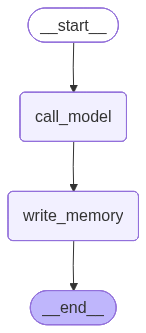

In [8]:
import re
import json

from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

    
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store, handling reasoning tags."""
    
    # 1. Setup Namespace
    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)

    # 2. Retrieve existing memory
    existing_memory = store.get(namespace, "user_memory")
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        # Use .get() to safely handle cases where the key might be missing
        formatted_memory = (
            f"Name: {memory_dict.get('name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = "No existing memory."

    # 3. Prepare the Model
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)
    
    # Invoke the model (using the standard model to handle raw reasoning output)
    response = model.invoke([SystemMessage(content=system_msg)] + state['messages'])
    raw_content = response.content

    # 4. PRE-PROCESSING: Extract JSON block
    # This regex is crucial for filtering out <think> tags or conversational filler
    try:
        json_match = re.search(r'\{.*\}', raw_content, re.DOTALL)
        if json_match:
            clean_json_str = json_match.group(0)
            data_to_save = json.loads(clean_json_str)
            
            # 5. Save the data to the store only if extraction was successful
            # We use "user_memory" as the fixed key for the user's profile
            store.put(namespace, "user_memory", data_to_save)
            # print("Memory saved successfully.") # Helpful for debugging on your i5
            
        else:
            # If no JSON braces found, the model likely didn't find new info to save
            print("No valid memory structure found in response.")
            
    except json.JSONDecodeError as e:
        print(f"Failed to parse memory JSON. Raw output was: {raw_content}")
        # We return an empty list to keep the graph moving without crashing
        return {"messages": []}

    # Return an empty list so we don't accidentally duplicate the AI's last message
    return {"messages": []}


# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [9]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.
================================== Ai Message ==================================

Hi Lance! That sounds like such a great way to explore San Francisco—biking allows you to take in the city’s scenic routes and hidden gems while staying active. Do you have a favorite trail or neighborhood to ride through? As for bakeries, I’ve heard great things about places like **Boudin Bakery & Café** (a historic spot with sourdough) and **La Panaderia** for their pastries. Have you tried any local favorites yet? I’d love to hear your recommendations too! 🚴‍♂️🥐
================================== Ai Message ==================================

Hi Lance! That sounds like such a great way to explore San Francisco—biking allows you to take in the city’s scenic routes and hidden gems while staying active. Do you have a favorite trail or neighborh

Let's check the memory in the store. 

We can see that the memory is a dictionary that matches our schema.

In [10]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'name': 'Lance',
 'interests': {'activities': ['biking'],
  'locations': ['San Francisco'],
  'food': ['bakeries']},
 'preferences': {'transportation': 'bike',
  'exploration_style': 'active and scenic'},
 'notes': "Lance enjoys biking around San Francisco and eating at bakeries. He hasn't specified favorite trails or bakeries yet. Open to recommendations and sharing more details."}

## When can this fail?

[`with_structured_output`](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) is very useful, but what happens if we're working with a more complex schema? 

[Here's](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) an example of a more complex schema, which we'll test below. 

This is a [Pydantic](https://docs.pydantic.dev/latest/) model that describes a user's preferences for communication and trust fall.

In [11]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

Now, let's try extraction of this schema using the `with_structured_output` method.

In [12]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

If we naively extract more complex schemas, even using high capacity model like `gpt-4o`, it is prone to failure.


## Trustcall for creating and updating profile schemas

As we can see, working with schemas can be tricky.

Complex schemas can be difficult to extract. 

In addition, updating even simple schemas can pose challenges.

Consider our above chatbot. 

We regenerated the profile schema *from scratch* each time we chose to save a new memory.

This is inefficient, potentially wasting model tokens if the schema contains a lot of information to re-generate each time.

Worse, we may loose information when regenerating the profile from scratch.

Addressing these problems is the motivation for [TrustCall](https://github.com/hinthornw/trustcall)!

This is an open-source library for updating JSON schemas developed by one [Will Fu-Hinthorn](https://github.com/hinthornw) on the LangChain team.

It's motivated by exactly these challenges while working on memory.

Let's first show simple usage of extraction with TrustCall on this list of [messages](https://docs.langchain.com/oss/python/langchain/messages).


In [13]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="I really like biking around San Francisco.")]

We use `create_extractor`, passing in the model as well as our schema as a [tool](https://docs.langchain.com/oss/python/langchain/tools).

With TrustCall, can supply supply the schema in various ways. 

For example, we can pass a JSON object / Python dictionary or Pydantic model.

Under the hood, TrustCall uses [tool calling](https://docs.langchain.com/oss/python/langchain/models#tool-calling) to produce [structured output](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) from an input list of [messages](https://docs.langchain.com/oss/python/langchain/messages).

To force Trustcall to produce structured output, we can include the schema name in the `tool_choice` argument.

We can invoke the extractor with  the above conversation.

In [14]:
from trustcall import create_extractor

# Schema 
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

# Initialize the model
model = ChatOllama(model="qwen3:8b", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

When we invoke the extractor, we get a few things:

* `messages`: The list of `AIMessages` that contain the tool calls. 
* `responses`: The resulting parsed tool calls that match our schema.
* `response_metadata`: Applicable if updating existing tool calls. It says which of the responses correspond to which of the existing objects.


In [15]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (05acd74c-833b-4871-a117-06f50173d65d)
 Call ID: 05acd74c-833b-4871-a117-06f50173d65d
  Args:
    user_name: Lance
    interests: ['biking']


In [16]:
schema = result["responses"]
schema

[UserProfile(user_name='Lance', interests=['biking'])]

In [17]:
schema[0].model_dump()

{'user_name': 'Lance', 'interests': ['biking']}

In [18]:
result["response_metadata"]

[{'id': '05acd74c-833b-4871-a117-06f50173d65d'}]

Let's see how we can use it to *update* the profile.

For updating, TrustCall takes a set of messages as well as the existing schema. 

The central idea is that it prompts the model to produce a [JSON Patch](https://jsonpatch.com/) to update only the relevant parts of the schema.

This is less error-prone than naively overwriting the entire schema.

It's also more efficient since the model only needs to generate the parts of the schema that have changed.

We can save the existing schema as a dict.

We can use `model_dump()` to serialize a Pydantic model instance into a dict. 

We pass it to the `"existing"` argument along with the schema name, `UserProfile`. 

In [19]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Lance."), 
                        AIMessage(content="Nice to meet you, Lance."), 
                        HumanMessage(content="I really like biking around San Francisco."),
                        AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})  

In [20]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (1edd2759-978b-4423-864b-5def7a9b2d47)
 Call ID: 1edd2759-978b-4423-864b-5def7a9b2d47
  Args:
    user_name: Lance
    interests: ['biking', 'bakery']


In [21]:
result["response_metadata"]

[{'id': '1edd2759-978b-4423-864b-5def7a9b2d47'}]

In [22]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Lance', 'interests': ['biking', 'bakery']}

LangSmith trace:

https://smith.langchain.com/public/229eae22-1edb-44c6-93e6-489124a43968/r

Now, let's also test Trustcall on the [challenging schema](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) that we saw earlier.

In [23]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"][0]

TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=None, favorite_telegram_operators=None, preferred_telegram_paper=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Daredevil')]), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', sentence_preference_revealed='straight key')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher', sentence_preference_revealed='higher')], trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_revealed='diamond formation')])))

Trace: 

https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r

For more examples, you can see an overview video [here](https://www.youtube.com/watch?v=-H4s0jQi-QY).

## Chatbot with profile schema updating

Now, let's bring Trustcall into our chatbot to create *and update* a memory profile.

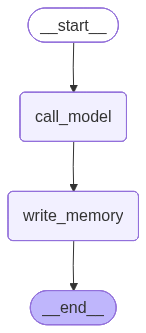

In [26]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOllama(model="qwen3:8b", temperature=0)

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store."""
    
    # 1. Setup
    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)

    # 2. Retrieve existing memory
    existing_memory = store.get(namespace, "user_memory")
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # 3. Invoke the extractor
    result = trustcall_extractor.invoke({
        "messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"], 
        "existing": existing_profile
    })
    
    # 4. Defensive Check: Only save if the model actually extracted something
    # result["responses"] is a list. If it's empty, indexing [0] crashes.
    if result["responses"]:
        updated_profile = result["responses"][0].model_dump()

        # 5. Save the updated profile
        key = "user_memory"
        store.put(namespace, key, updated_profile)
        # print("Memory updated!") # Optional debug print
    else:
        # If the list is empty, just do nothing and move to END
        print("No new profile information detected to save.")

    return {"messages": []}

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [27]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! 😊 How can I assist you today? Let me know if you need help with anything!
No new profile information detected to save.
================================== Ai Message ==================================

Hello, Lance! 😊 How can I assist you today? Let me know if you need help with anything!


In [28]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a great way to explore San Francisco! 🚴‍♂️ The city has some amazing bike paths and scenic routes. Here are a few tips and ideas:  

1. **Hills & Weather**: Be prepared for steep inclines (like Russian Hill or Loma Verde) and sudden weather changes. Layer up!  
2. **Popular Routes**:  
   - **Presidio Trail**: A peaceful loop with views of the Golden Gate Bridge.  
   - **Embarcadero**: Follow the waterfront path for panoramic city views.  
   - **Mission District**: Explore vibrant neighborhoods with bike-friendly streets.  
3. **Safety**: Use bike lanes where available, and watch out for traffic, especially near downtown.  
4. **Rentals**: Check out [Bay Wheels](https://www.baywheels.com/) for bike rentals or ride-sharing services.  

Need help planning a specific route 

In [29]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Lance',
  'user_location': 'San Francisco',
  'interests': ['biking']},
 'created_at': '2026-01-30T22:42:15.160305+00:00',
 'updated_at': '2026-01-30T22:42:15.160307+00:00'}

In [30]:
# The user profile saved as a JSON object
existing_memory.value

{'user_name': 'Lance',
 'user_location': 'San Francisco',
 'interests': ['biking']}

In [31]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

That’s fantastic! San Francisco has some incredible bakeries that pair perfectly with a bike ride. Here are a few favorites in different neighborhoods, along with tips for enjoying them after a ride:  

### 🍞 **Popular Bakeries in SF**  
1. **Boudin Bakery & Café** (Fisherman’s Wharf)  
   - A historic spot with sourdough bread and iconic "Boudin" rolls. Great for a post-ride treat with a view of the bay.  
   - **Pro Tip**: Grab a coffee and a roll while people-watching at the wharf.  

2. **La Panadería** (Mission District)  
   - A cozy spot known for its buttery pastries, flaky croissants, and daily bread. Perfect for a sweet break after exploring the Mission’s murals.  
   - **Pro Tip**: Try their *pan de coco* (coconut bread) for a local flavor.  

3. **Café Grumpy** (Outer Sunset)  
   -

Continue the conversation in a new thread.

In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?


Trace:

https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r

## Studio

![Screenshot 2024-10-30 at 11.26.31 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0437060f1754ea79908_Screenshot%202024-11-11%20at%207.48.53%E2%80%AFPM.png)